# Setting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import random
import gc
import re
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import resample, shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
def conf_matrix(y_true, y_pred):    
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    mat = confusion_matrix(y_true, y_pred)
    labels = ['0(Non Risk)', '1(Risk)']
    colors=['whitesmoke', 'steelblue']
    sns.heatmap(mat, annot=True, cmap=colors, xticklabels=labels, yticklabels=labels, fmt="d")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    print('Accuracy:', acc)
    print('Recall:', recall)
    print('Precision:', precision)
    print('F1:', f1)

In [3]:
def seed_everything(seed = 21):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything()

# Data Import

In [4]:
data = pd.read_csv('./DA_data_mean.csv', index_col=0)

data.gender = data.gender.replace({'M':1, 'F':0})
y = data.mortality_in_3days.replace({True:1, False:0})

X = data.drop(['hadm_id', 'intime', 'mortality_in_second', 'mortality_in_3days'], axis=1)
X.fillna(0, inplace=True)

del data
gc.collect()

0

In [5]:
# SHAP-based Feature Importance
shap_fi = pd.read_csv('./shap_fi_mean.csv', index_col=0)

# non-zero Shapley value -> 514 features
X = X[shap_fi.iloc[:514, :].column_name.values]

X, y = shuffle(X, y, random_state=21)

X_normal = X[y==0]
X_abnormal = X[y==1]
y_normal = y[y==0]
y_abnormal = y[y==1]

In [6]:
X_train_normal = X_normal.iloc[:60000, :]
X_train_abnormal = X_abnormal.iloc[:2000, :]

X_test_normal = X_normal.iloc[60000:, :]
X_test_abnormal = X_abnormal.iloc[2000:, :]

y_train_normal = y_normal[:60000]
y_train_abnormal = y_abnormal[:2000]

y_test_normal = y_normal[60000:]
y_test_abnormal = y_abnormal[2000:]

X_train_all = pd.concat([X_train_normal, X_train_abnormal])
X_test = pd.concat([X_test_normal, X_test_abnormal])

y_train_all = pd.concat([y_train_normal, y_train_abnormal])
y_test = pd.concat([y_test_normal, y_test_abnormal])

X_train_all.shape, X_test.shape

((62000, 514), (7185, 514))

In [7]:
ss = StandardScaler()

X_train_all_std = ss.fit_transform(X_train_all)
X_test.iloc[:, :] = ss.transform(X_test)

In [26]:
# upsample -> abnormal(dies in 3 days) case 
X_train_normal = X_train_all[y_train_all==0]
X_train_abnormal = X_train_all[y_train_all==1]

y_train_normal = y_train_all[y_train_all==0]
y_train_abnormal = y_train_all[y_train_all==1]
    
X_abnormal_res, y_abnormal_res = resample(X_train_abnormal, y_train_abnormal, replace=True, n_samples=X_train_normal.shape[0], random_state=21)
X_train_all = pd.concat([X_train_normal, X_abnormal_res])
y_train_all = pd.concat([y_train_normal, y_abnormal_res])
    
# shuffle 
X_res_all, y_res_all = shuffle(X_train_all, y_train_all, random_state=21)

ss = StandardScaler()
X_res_all = ss.fit_transform(X_res_all)

# X_res_all : no validation subset 
X_res_all.shape 

(120000, 514)

# XGBoost

In [8]:
def xgb_objective(trial, X, y):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    cv_scores = []
    
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # using statistic of X_train
        ss = StandardScaler()
        X_train.iloc[:, :] = ss.fit_transform(X_train)
        X_val.iloc[:, :] = ss.transform(X_val)

        model = XGBClassifier(seed=21, **params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        cv_scores.append(f1_score(y_val, y_pred))

    f1 = np.mean(cv_scores)
    
    return f1

In [9]:
xgb_study = optuna.create_study(study_name='XGBoost', direction='maximize', sampler=TPESampler(seed=21))
# non-scaled X_train_all
xgb_study.optimize(lambda trial: xgb_objective(trial, X_train_all, y_train_all), n_trials=30)

print()
print("Best Score:", xgb_study.best_value)
print("Best trial:", xgb_study.best_trial.params)

[I 2023-12-01 01:39:29,540] A new study created in memory with name: XGBoost
[I 2023-12-01 01:40:02,881] Trial 0 finished with value: 0.2343110603330183 and parameters: {'max_depth': 1, 'learning_rate': 0.03786337472419078, 'n_estimators': 375, 'min_child_weight': 1, 'gamma': 4.439991330753759e-07, 'subsample': 0.012634164097731817, 'colsample_bytree': 0.040229421544244505, 'reg_alpha': 0.0020477755673855434, 'reg_lambda': 2.916857051715679e-06}. Best is trial 0 with value: 0.2343110603330183.
[I 2023-12-01 01:41:14,416] Trial 1 finished with value: 0.378145988951924 and parameters: {'max_depth': 6, 'learning_rate': 0.01377659556728088, 'n_estimators': 441, 'min_child_weight': 2, 'gamma': 2.6607084720804786e-07, 'subsample': 0.09814294812495114, 'colsample_bytree': 0.533825467560499, 'reg_alpha': 0.011791001214409286, 'reg_lambda': 0.5806053091762127}. Best is trial 1 with value: 0.378145988951924.
[I 2023-12-01 01:42:04,023] Trial 2 finished with value: 0.43324995205695505 and paramet


Best Score: 0.4497525623455272
Best trial: {'max_depth': 4, 'learning_rate': 0.24132731103676655, 'n_estimators': 328, 'min_child_weight': 10, 'gamma': 0.0022854347784250217, 'subsample': 0.9602305976883808, 'colsample_bytree': 0.9957229226622987, 'reg_alpha': 5.398110268118385e-05, 'reg_lambda': 2.9103899965462842e-05}


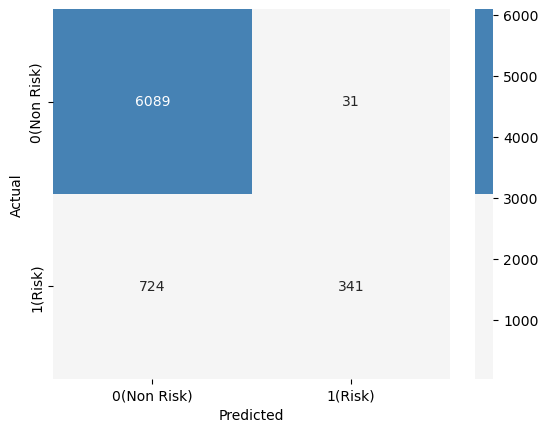

Accuracy: 0.894919972164231
Recall: 0.32018779342723
Precision: 0.9166666666666666
F1: 0.4745998608211552


In [10]:
xgb = XGBClassifier(seed=21, **xgb_study.best_trial.params)
# scaled X_train_all_std
xgb.fit(X_train_all_std, y_train_all)

preds = xgb.predict(X_test.values)
conf_matrix(y_test, preds)

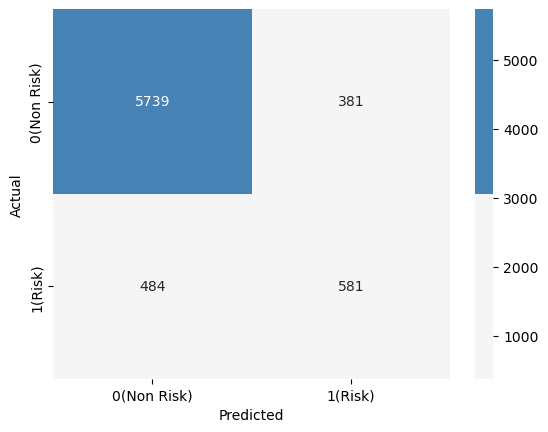

Accuracy: 0.8796102992345164
Recall: 0.5455399061032864
Precision: 0.603950103950104
F1: 0.5732609768130242


In [28]:
xgb_res = XGBClassifier(seed=21, **xgb_study.best_trial.params)
# X_res_all : oversampled
xgb_res.fit(X_res_all, y_res_all)

preds = xgb_res.predict(X_test.values)
conf_matrix(y_test, preds)

In [33]:
# save model
# better F1
joblib.dump(xgb_res, 'XGBoost_tuned.pkl')

['XGBoost_tuned.pkl']

# LightGBM

In [12]:
def lgbm_objective(trial, X, y):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    cv_scores = []
    
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # using statistic of X_train
        ss = StandardScaler()
        X_train.iloc[:, :] = ss.fit_transform(X_train)
        X_val.iloc[:, :] = ss.transform(X_val)

        model = LGBMClassifier(seed=21, **params)
        model.fit(X_train.values, y_train)
        y_pred = model.predict(X_val.values)
        cv_scores.append(f1_score(y_val, y_pred))

    f1 = np.mean(cv_scores)
    
    return f1

In [13]:
lgbm_study = optuna.create_study(study_name='LightGBM', direction='maximize', sampler=TPESampler(seed=21))
# non-scaled X_train_all
lgbm_study.optimize(lambda trial: lgbm_objective(trial, X_train_all, y_train_all), n_trials=30)

print()
print("Best Score:", lgbm_study.best_value)
print("Best trial:", lgbm_study.best_trial.params)

[I 2023-12-01 02:00:00,077] A new study created in memory with name: LightGBM
[I 2023-12-01 02:00:33,587] Trial 0 finished with value: 0.35300598793279725 and parameters: {'lambda_l1': 2.744883567583618e-08, 'lambda_l2': 3.999327211568993e-06, 'num_leaves': 185, 'feature_fraction': 0.4129697499495699, 'bagging_fraction': 0.5235536591604635, 'bagging_freq': 1, 'min_child_samples': 34}. Best is trial 0 with value: 0.35300598793279725.
[I 2023-12-01 02:01:06,639] Trial 1 finished with value: 0.38753225664216123 and parameters: {'lambda_l1': 0.00944479751524869, 'lambda_l2': 5.929656545767071e-06, 'num_leaves': 150, 'feature_fraction': 0.44174257276756035, 'bagging_fraction': 0.920442690395853, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 1 with value: 0.38753225664216123.
[I 2023-12-01 02:01:47,398] Trial 2 finished with value: 0.3988520176566275 and parameters: {'lambda_l1': 0.000290647069480674, 'lambda_l2': 0.5933306739409402, 'num_leaves': 195, 'feature_fraction': 0.9822


Best Score: 0.4353337958142835
Best trial: {'lambda_l1': 4.877874523236545e-06, 'lambda_l2': 3.5932497602748015e-06, 'num_leaves': 85, 'feature_fraction': 0.6760842002757856, 'bagging_fraction': 0.7266210156745826, 'bagging_freq': 2, 'min_child_samples': 81}


[LightGBM] [Warning] feature_fraction is set=0.6760842002757856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6760842002757856
[LightGBM] [Warning] lambda_l1 is set=4.877874523236545e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.877874523236545e-06
[LightGBM] [Warning] lambda_l2 is set=3.5932497602748015e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5932497602748015e-06
[LightGBM] [Warning] bagging_fraction is set=0.7266210156745826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7266210156745826
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6760842002757856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6760842002757856
[LightGBM] [Warning] lambda_l1 is set=4.877874523236545e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.877874523236545e-06
[LightGBM] [Warni

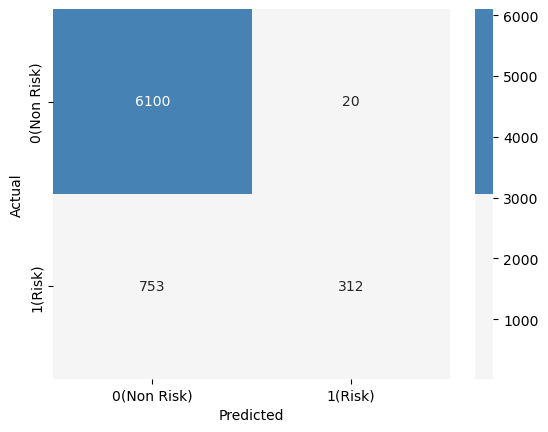

Accuracy: 0.8924147529575505
Recall: 0.29295774647887324
Precision: 0.9397590361445783
F1: 0.44667143879742305


In [14]:
lgbm = LGBMClassifier(seed=21, **lgbm_study.best_trial.params)
# scaled X_train_all_std
lgbm.fit(X_train_all_std, y_train_all)

preds = lgbm.predict(X_test.values)
conf_matrix(y_test, preds)

[LightGBM] [Warning] feature_fraction is set=0.6760842002757856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6760842002757856
[LightGBM] [Warning] lambda_l1 is set=4.877874523236545e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.877874523236545e-06
[LightGBM] [Warning] lambda_l2 is set=3.5932497602748015e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5932497602748015e-06
[LightGBM] [Warning] bagging_fraction is set=0.7266210156745826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7266210156745826
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6760842002757856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6760842002757856
[LightGBM] [Warning] lambda_l1 is set=4.877874523236545e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.877874523236545e-06
[LightGBM] [Warni

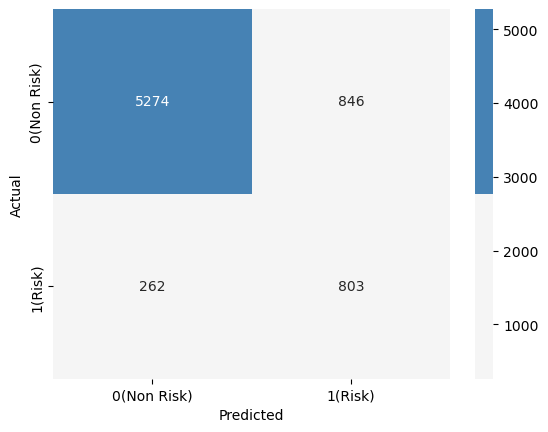

Accuracy: 0.8457898399443284
Recall: 0.7539906103286385
Precision: 0.48696179502728926
F1: 0.5917464996315401


In [30]:
lgbm_res = LGBMClassifier(seed=21, **lgbm_study.best_trial.params)
# X_res_all : oversampled
lgbm_res.fit(X_res_all, y_res_all)

preds = lgbm_res.predict(X_test.values)
conf_matrix(y_test, preds)

In [34]:
# save model
# better F1
joblib.dump(lgbm_res, 'LightGBM_tuned.pkl')

['LightGBM_tuned.pkl']

# RandomForest

In [16]:
def rf_objective(trial, X, y):
    params = {

        'max_depth' : trial.suggest_int('max_depth', 1, 20),
        'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
        'n_estimators' :  trial.suggest_int('n_estimators', 100, 500)
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    cv_scores = []
    
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # using statistic of X_train
        ss = StandardScaler()
        X_train.iloc[:, :] = ss.fit_transform(X_train)
        X_val.iloc[:, :] = ss.transform(X_val)

        model = RandomForestClassifier(random_state=21, **params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        cv_scores.append(f1_score(y_val, y_pred))

    f1 = np.mean(cv_scores)
    
    return f1

In [17]:
rf_study = optuna.create_study(study_name='RandomForest', direction='maximize', sampler=TPESampler(seed=21))
# non-scaled X_train_all
rf_study.optimize(lambda trial: rf_objective(trial, X_train_all, y_train_all), n_trials=30)

print()
print("Best Score:", rf_study.best_value)
print("Best trial:", rf_study.best_trial.params)

[I 2023-12-01 02:13:09,330] A new study created in memory with name: RandomForest
[I 2023-12-01 02:13:41,325] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 1, 'max_leaf_nodes': 290, 'n_estimators': 389}. Best is trial 0 with value: 0.0.
[I 2023-12-01 02:13:54,237] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 1, 'max_leaf_nodes': 207, 'n_estimators': 120}. Best is trial 0 with value: 0.0.
[I 2023-12-01 02:15:32,286] Trial 2 finished with value: 0.11240579011454606 and parameters: {'max_depth': 7, 'max_leaf_nodes': 665, 'n_estimators': 223}. Best is trial 2 with value: 0.11240579011454606.
[I 2023-12-01 02:18:53,998] Trial 3 finished with value: 0.12565172108754835 and parameters: {'max_depth': 12, 'max_leaf_nodes': 71, 'n_estimators': 447}. Best is trial 3 with value: 0.12565172108754835.
[I 2023-12-01 02:19:48,625] Trial 4 finished with value: 0.0009975062344139652 and parameters: {'max_depth': 3, 'max_leaf_nodes': 179, 'n_estimators': 298}. Best is t


Best Score: 0.21708013017746902
Best trial: {'max_depth': 20, 'max_leaf_nodes': 1000, 'n_estimators': 315}


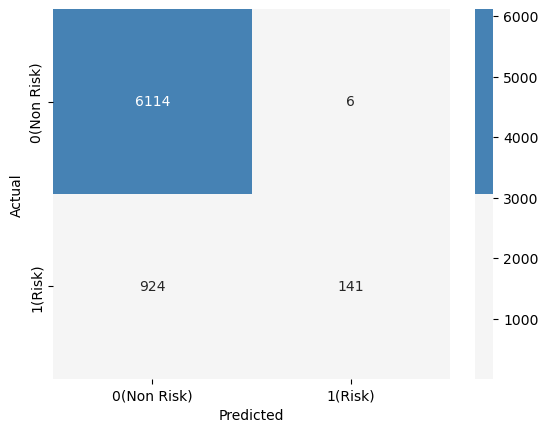

Accuracy: 0.8705636743215032
Recall: 0.1323943661971831
Precision: 0.9591836734693877
F1: 0.23267326732673263


In [18]:
rf = RandomForestClassifier(random_state=21, **rf_study.best_trial.params)
# scaled X_train_all_std
rf.fit(X_train_all_std, y_train_all)

preds = rf.predict(X_test.values)
conf_matrix(y_test, preds)

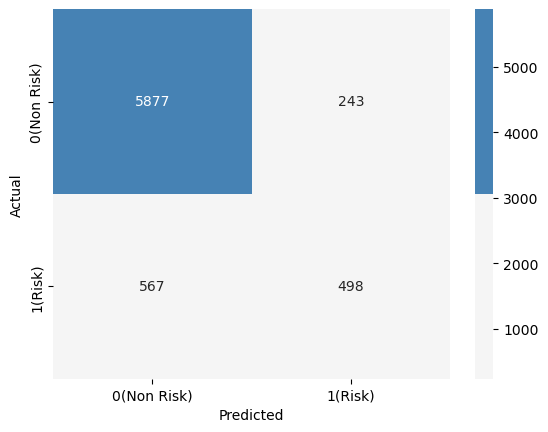

Accuracy: 0.8872651356993737
Recall: 0.4676056338028169
Precision: 0.6720647773279352
F1: 0.5514950166112956


In [31]:
rf_res = RandomForestClassifier(random_state=21, **rf_study.best_trial.params)
# X_res_all : oversampled
rf_res.fit(X_res_all, y_res_all)

preds = rf_res.predict(X_test.values)
conf_matrix(y_test, preds)

In [35]:
# save model
# better F1
joblib.dump(rf_res, 'RandomForest_tuned.pkl')

['RandomForest_tuned.pkl']

# Logistic Regression

In [20]:
def lr_objective(trial, X, y):
    params = {
        'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
        'C' : trial.suggest_loguniform("C", 1e-2, 1e2),
        "n_jobs" : -1
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    cv_scores = []
    
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # using statistic of X_train
        ss = StandardScaler()
        X_train.iloc[:, :] = ss.fit_transform(X_train)
        X_val.iloc[:, :] = ss.transform(X_val)

        model = LogisticRegression(random_state=21, **params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        cv_scores.append(f1_score(y_val, y_pred))

    f1 = np.mean(cv_scores)
    
    return f1

In [21]:
lr_study = optuna.create_study(study_name='LogisticRegression', direction='maximize', sampler=TPESampler(seed=21))
# non-scaled X_train_all
lr_study.optimize(lambda trial: lr_objective(trial, X_train_all, y_train_all), n_trials=30)

print()
print("Best Score:", lr_study.best_value)
print("Best trial:", lr_study.best_trial.params)

[I 2023-12-01 04:42:06,665] A new study created in memory with name: LogisticRegression
[I 2023-12-01 04:42:30,693] Trial 0 finished with value: 0.34488933907666747 and parameters: {'tol': 4.967615592831817e-05, 'C': 0.14336351455044888}. Best is trial 0 with value: 0.34488933907666747.
[I 2023-12-01 04:42:49,822] Trial 1 finished with value: 0.3392876766701901 and parameters: {'tol': 0.0007212453804843987, 'C': 0.012202954716409928}. Best is trial 0 with value: 0.34488933907666747.
[I 2023-12-01 04:43:08,158] Trial 2 finished with value: 0.3426340331595115 and parameters: {'tol': 0.00020671684250217162, 'C': 0.015962210244841568}. Best is trial 0 with value: 0.34488933907666747.
[I 2023-12-01 04:43:29,122] Trial 3 finished with value: 0.35060930348656305 and parameters: {'tol': 0.0003029696220706523, 'C': 4.525235427450762}. Best is trial 3 with value: 0.35060930348656305.
[I 2023-12-01 04:43:51,675] Trial 4 finished with value: 0.3485846838554588 and parameters: {'tol': 0.00030880627


Best Score: 0.35701499978050066
Best trial: {'tol': 0.00021184813014362553, 'C': 7.056070774696013}


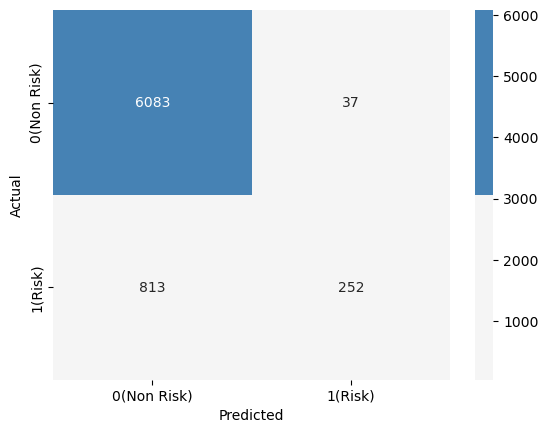

Accuracy: 0.8816979819067502
Recall: 0.23661971830985915
Precision: 0.8719723183391004
F1: 0.3722304283604136


In [22]:
lr = LogisticRegression(random_state=21, **lr_study.best_trial.params)
# scaled X_train_all_std
lr.fit(X_train_all_std, y_train_all)

preds = lr.predict(X_test.values)
conf_matrix(y_test, preds)

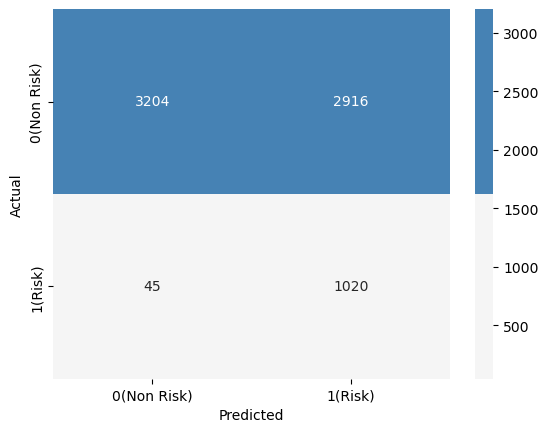

Accuracy: 0.5878914405010438
Recall: 0.9577464788732394
Precision: 0.25914634146341464
F1: 0.40791841631673664


In [32]:
lr_res = LogisticRegression(random_state=21, **lr_study.best_trial.params)
# X_res_all : oversampled
lr_res.fit(X_res_all, y_res_all)

preds = lr_res.predict(X_test.values)
conf_matrix(y_test, preds)

In [36]:
# save model
# not too much false positive..
joblib.dump(lr, 'LogisticRegression_tuned.pkl')

['LogisticRegression_tuned.pkl']